# Basic workflow with ART for evasion attacks and defences

In this notebook we will show
- how to work with a Keras image classifier in ART
- how ART abstracts from the specific ML/DL backend
- how to apply a Projected Gradient Descent (PGD) evasion attack against that classifier
- how to deploy defences against such attacks
- how to create adversarial samples that can bypass those defences

## Install and load prerequisites

You can preinstall all prerequisites by uncommenting and running the following cell.

In [1]:
# Load basic dependencies:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import sys
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet50, resnet18
from torchvision import transforms
from PIL import Image
from PIL import Image as PILImage

# Load ART dependencies:
# from art.estimators.classification import KerasClassifier
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.preprocessor import SpatialSmoothing
from art.utils import to_categorical

# Install ImageNet stubs:
#!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

## Load images

We are going to load a set of 16 example images for illustration purposes.

In [2]:
images_list = list()
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = PILImage.open(image_path).resize((224, 224))
    im = np.array(im)
    images_list.append(im)
    if 'unicycle.jpg' in image_path:
        # get unicycle index
        unicycle_idx = i
images = np.array(images_list)

The images all have a resolution of 224 x 224 pixels, and 3 color channels (RGB).

In [3]:
print('Number of images:', images.shape[0])
print('Dimension of images:', images.shape[1], 'x', images.shape[2], 'pixels')
print('Number of color channels:', images.shape[3], '(RGB)')

Number of images: 16
Dimension of images: 224 x 224 pixels
Number of color channels: 3 (RGB)


As default choice, we are going to use the unicycle image for illustration purposes. But you could use any other of the 16 images in the following (just change the value of the `idx` variable).

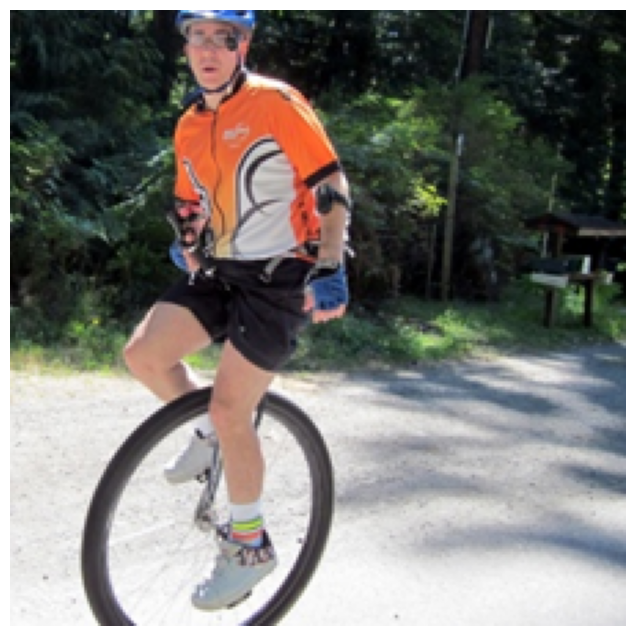

In [4]:
idx = unicycle_idx

plt.figure(figsize=(8,8)); plt.imshow(images[idx] / 255); plt.axis('off'); plt.show()

## Load ResNet50 classifier

Next we are going to use a state-of-the-art classifier on those images.

In [15]:
# This loads the pretrained ResNet50 model:
model = resnet18(pretrained=True)
#model = resnet50(pretrained=True)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's look at the prediction that this model yields for the selected image:

In [16]:
from torchvision.models import ResNet18_Weights
transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

In [17]:
# We need to expand the input dimension and apply the preprocessing required for ResNet50:
x = np.expand_dims(images[idx].copy(), axis=0)
# x = preprocess_input(x)
x = transform(PILImage.fromarray(x[0]))

# Then apply the model, determine the predicted label and confidence:
# pred = model.predict(x)
pred = model(x.unsqueeze(0))
pred = torch.nn.functional.softmax(pred, dim=1)
# label = np.argmax(pred, axis=1)[0]
label = np.argmax(pred.detach().numpy(), axis=1)[0]

confidence = pred[:,label][0]

print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction: unicycle, monocycle - confidence 0.99


In [18]:
label

np.int64(880)

So the model correctly tells us that this image shows a unicycle/monocycle, which is good :-)

Next we will create an ART KerasClassifier wrapper around the model. <br>
We need to take care of the `preprocess_input` logic that has to be applied:

- swap the order of the color channels (RGB -> BGR)
- subtract the channel means

In [19]:
from art.preprocessing.preprocessing import Preprocessor

class ResNet50Preprocessor(Preprocessor):

    def __call__(self, x, y=None):
        # return preprocess_input(x.copy()), y
        return transform(torch.tensor(x.copy())).numpy(), y


    def estimate_gradient(self, x, gradient):
        return gradient[..., ::-1] 

In [20]:
# Create the ART preprocessor and classifier wrapper:
preprocessor = ResNet50Preprocessor()
#classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=preprocessor)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 255),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),  # ResNet18 expects input shape (C, H, W)
    nb_classes=1000,
    #preprocessing=preprocessor
)


Now we will apply the classifier object to obtain the prediction.

**Note:** we have to swap the color channel order (from RGB to BGR) before feeding the input to the classifier

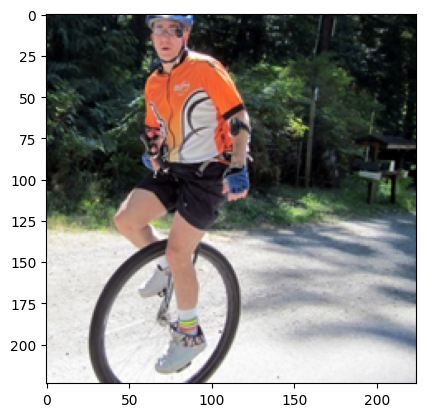

In [21]:
plt.imshow(images[idx])

In [22]:
print(images[idx].copy().shape)
x_art = np.expand_dims(images[idx].copy(), axis=0)
print('Shape of x_art:', x_art.shape)
x_art = np.transpose(x_art, (0, 3, 1, 2)).astype(np.float32)
print('Shape of x_art after transpose:', x_art.shape)

(224, 224, 3)
Shape of x_art: (1, 224, 224, 3)
Shape of x_art after transpose: (1, 3, 224, 224)


In [23]:

# Same as for the original model, we expand the dimension of the inputs.
x_art = transform(PILImage.fromarray(images[idx].copy())).numpy()
#x_art = images[idx].copy()

x_art = np.expand_dims(x_art, axis=0)  # Crop to 224x224

# Then apply the model through the classifier API, determine the predicted label and confidence:
pred = classifier.predict(x_art)
pred = torch.softmax(torch.from_numpy(pred), dim=1)
label = torch.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction:', label_to_name(label.item()), '- confidence {0:.2f}'.format(confidence))

Prediction: unicycle, monocycle - confidence 0.99


So through the classifier API we obtain the same predictions as from the raw model, but now we have an abstraction from the actual backend (e.g. Keras).

The classifier wrapper allows us to call other functions besides predict.

For example, we can obtain the **loss gradient** of the classifier, which is used in many of the algorithms for adversarial sample generation:

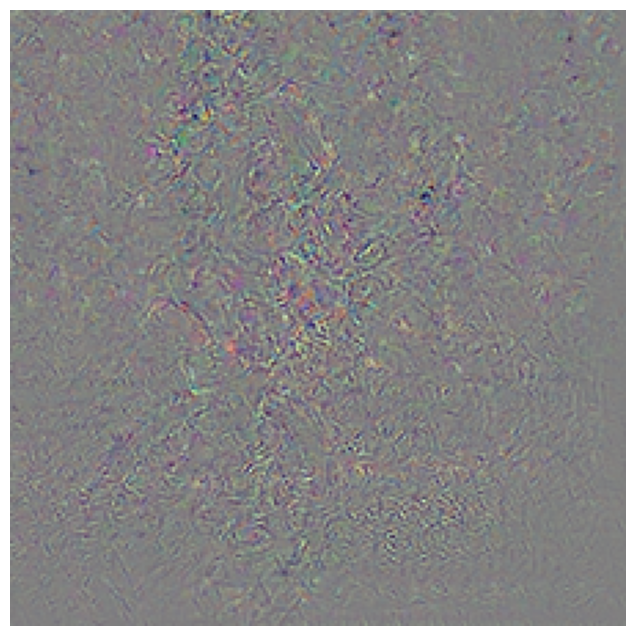

In [70]:
loss_gradient = classifier.loss_gradient(x=x_art, y=to_categorical([label], nb_classes=1000))
# Let's plot the loss gradient.

# Remove batch dimension: 
loss_gradient_plot = loss_gradient[0] 

# Then normalize loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot - loss_gradient_min)/(loss_gradient_max - loss_gradient_min)

# Convert to RGB format:
loss_gradient_plot = np.transpose(loss_gradient_plot, (1, 2, 0))  # Convert to HWC format
# Show plot:
plt.figure(figsize=(8,8)); plt.imshow(loss_gradient_plot); plt.axis('off'); plt.show()

## Create adversarial samples

Next, we are going to create an adversarial sample. <br>
We are going to use **Projected Gradient Descent (PGD)**, which is one of the strongest existing attacks. <br>
We will first perform an **untargeted** adversarial attack.

In [260]:
# TO check blurra un po
def unnormalize(x_art_adv):
    mean = np.array(transform.mean)[:, None, None]
    std = np.array(transform.std)[:, None, None]
    x_art_adv_unnorm = x_art_adv[0] * std + mean  # unnormalize
    x_art_adv_unnorm = np.clip(x_art_adv_unnorm, 0, 1)  # ensure values are in [0,1]
    x_art_adv_unnorm = np.transpose(x_art_adv_unnorm, (1, 2, 0))  # CHW -> HWC

    return x_art_adv_unnorm

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

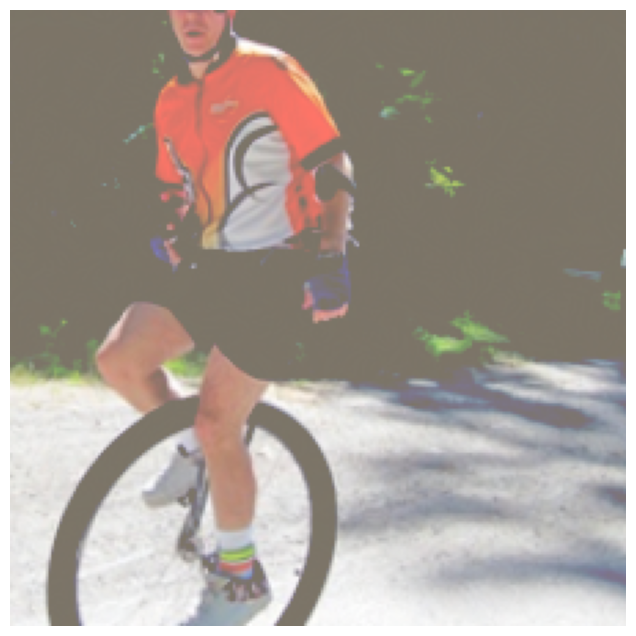

Prediction: American alligator, Alligator mississipiensis - confidence 0.82


In [261]:
# Create the attacker:
adv = ProjectedGradientDescent(classifier, targeted=False, max_iter=20, eps_step=0.001, eps=5, decay=0.9)


# x_art = torch.tensor(images[idx].copy())
# x_art = x_art.permute(2, 0, 1).float()
# x_art = np.expand_dims(x_art, axis=0)  # Crop to 224x224

x_art = np.array(images[idx].copy())
x_art = transform(PILImage.fromarray(x_art)).numpy()
x_art = np.expand_dims(x_art, axis=0)  # Crop to 224x224

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

x_art_adv_unnorm = unnormalize(x_art_adv)

plt.figure(figsize=(8,8))
plt.imshow(x_art_adv_unnorm)
plt.axis('off')
plt.show()



# Plot the adversarial sample (note: we swap color channels back to RGB order):
#plt.figure(figsize=(8,8)); plt.imshow(np.transpose(x_art_adv[0], (1, 2, 0))  / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
pred_adv = torch.softmax(torch.from_numpy(pred_adv), dim=1)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv.item()), '- confidence {0:.2f}'.format(confidence_adv))

Next, we will perform a **targeted attack** where we pick the class that we want the classifier to predict on the adversarial sample. <br>
Below is the list of labels and class names - make your pick!

In [236]:
for i in range(1000):
    print('label', i, '-', label_to_name(i))

label 0 - tench, Tinca tinca
label 1 - goldfish, Carassius auratus
label 2 - great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
label 3 - tiger shark, Galeocerdo cuvieri
label 4 - hammerhead, hammerhead shark
label 5 - electric ray, crampfish, numbfish, torpedo
label 6 - stingray
label 7 - cock
label 8 - hen
label 9 - ostrich, Struthio camelus
label 10 - brambling, Fringilla montifringilla
label 11 - goldfinch, Carduelis carduelis
label 12 - house finch, linnet, Carpodacus mexicanus
label 13 - junco, snowbird
label 14 - indigo bunting, indigo finch, indigo bird, Passerina cyanea
label 15 - robin, American robin, Turdus migratorius
label 16 - bulbul
label 17 - jay
label 18 - magpie
label 19 - chickadee
label 20 - water ouzel, dipper
label 21 - kite
label 22 - bald eagle, American eagle, Haliaeetus leucocephalus
label 23 - vulture
label 24 - great grey owl, great gray owl, Strix nebulosa
label 25 - European fire salamander, Salamandra salamandra
label 26 

As default, let's get this image misclassified as black swan (label 100)!

In [237]:
target_label = 100

Now let's perform the targeted attack:

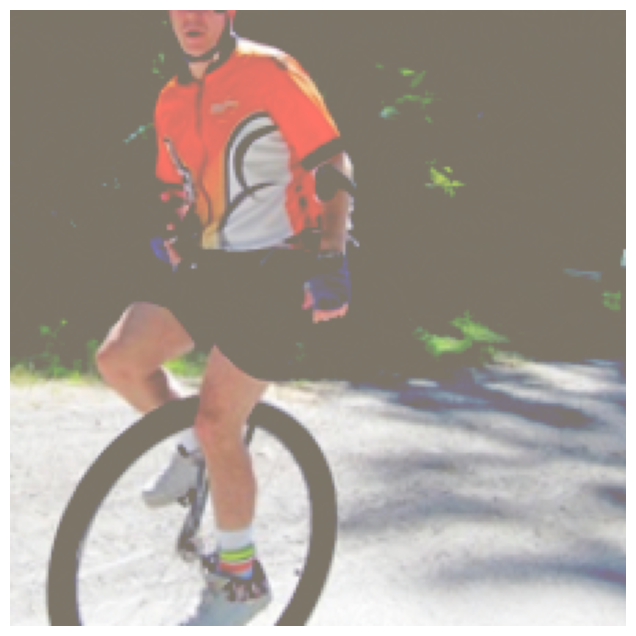

Prediction: black swan, Cygnus atratus - confidence 1.00


In [239]:
# Set the configuration to a targeted attack:
adv.set_params(targeted=True)

x_art = np.array(images[idx].copy())
x_art = transform(PILImage.fromarray(x_art)).numpy()
x_art = np.expand_dims(x_art, axis=0)  # Crop to 224x224

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art, y=to_categorical([target_label]))

# Unnormalize the adversarial image for visualization
# mean = np.array(transform.mean)[:, None, None]
# std = np.array(transform.std)[:, None, None]
# x_art_adv_unnorm = x_art_adv[0] * std + mean  # unnormalize
# x_art_adv_unnorm = np.clip(x_art_adv_unnorm, 0, 1)  # ensure values are in [0,1]
# x_art_adv_unnorm = np.transpose(x_art_adv_unnorm, (1, 2, 0))  # CHW -> HWC
x_art_adv_unnorm = unnormalize(x_art_adv)

plt.figure(figsize=(8,8))
plt.imshow(x_art_adv_unnorm)
plt.axis('off')
plt.show()


# Plot the adversarial sample (note: we swap color channels back to RGB order):
#plt.figure(figsize=(8,8)); plt.imshow(np.transpose(x_art_adv[0], (1, 2, 0))  / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
#x_art_adv = transform(torch.tensor(x_art_adv)).numpy()
pred_adv = classifier.predict(x_art_adv)
pred_adv = torch.softmax(torch.from_numpy(pred_adv), dim=1)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv.item()), '- confidence {0:.2f}'.format(confidence_adv))

We can measure the quantity of perturbation that was added to the image using different $\ell_p$ norms. <br>
**Note:** the PGD attack controls the $\ell_\infty$ norm via the `epsilon` parameter.

In [240]:
l_0 = int(99*len(np.where(np.abs(x_art[0] - x_art_adv[0])>0.5)[0]) / (224*224*3)) + 1   
l_1 = int(99*np.sum(np.abs(x_art[0] - x_art_adv[0])) / np.sum(np.abs(x_art[0]))) + 1
l_2 = int(99*np.linalg.norm(x_art[0] - x_art_adv[0]) / np.linalg.norm(x_art[0])) + 1 
l_inf = int(99*np.max(np.abs(x_art[0] - x_art_adv[0])) / 255) + 1

print('Perturbation l_0 norm: %d%%' % l_0)
print('Perturbation l_1 norm: %d%%' % l_1)
print('Perturbation l_2 norm: %d%%' % l_2)
print('Noise l_inf norm: %d%%' % l_inf)

# Let's also plot the absolute amount of adversarial pixel perturbations:
pert = np.abs(x_art[0] - x_art_adv[0])[..., ::-1]
pert_min = np.min(pert)
pert_max = np.max(pert)
#plt.figure(figsize=(8,8)); plt.imshow((pert - pert_min) / (pert_max - pert_min)); plt.axis('off'); plt.show()

Perturbation l_0 norm: 47%
Perturbation l_1 norm: 52%
Perturbation l_2 norm: 69%
Noise l_inf norm: 1%


## Apply defences

Next we are going to apply a simple input preprocessing defence: Spatial Smoothing. <br>
Ideally, we want this defence to result in correct predictions when applied both to the original and the adversarial images.

Prediction of original sample: unicycle, monocycle - confidence 0.99
Prediction of adversarial sample: unicycle, monocycle - confidence 0.93


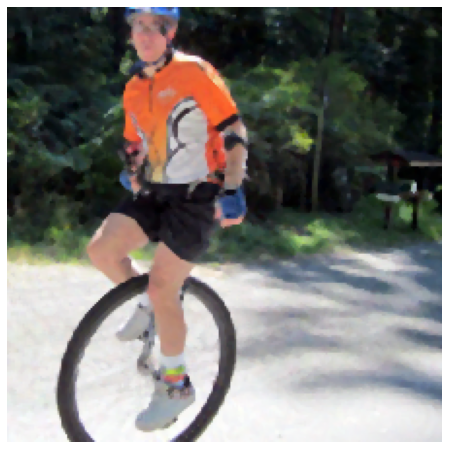

In [16]:
# Initialize the SpatialSmoothing defence. 
ss = SpatialSmoothing(window_size=3)

# Apply the defence to the original input and to the adversarial sample, respectively:
x_art_def, _ = ss(x_art)
x_art_adv_def, _ = ss(x_art_adv)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

# Print the predictions:
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))

# Show the preprocessed adversarial sample:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

## Perform adaptive whitebox attack to defeat defences

Next we are going to mount an adaptive whitebox attack in which the attacker aims at defeating the defence that we just put into place.

First, we create a classifier which incorporates the defence:

In [17]:
classifier_def = KerasClassifier(preprocessing=preprocessor, preprocessing_defences=[ss], clip_values=(0, 255), 
                                 model=model)

# Now we apply this classifier to the adversarial sample from before:
pred_def = classifier_def.predict(x_art_adv)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

print('Prediction:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))

Prediction: unicycle, monocycle - confidence 0.93


We observe that this classifier reproduces the prediction that we had obtained before by manually applying the input preprocessing defence.

Now we create an adversarial sample against the *defended* classifier. <br>
As we are going to see, this adversarial sample is able to bypass the input preprocessing defence.

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

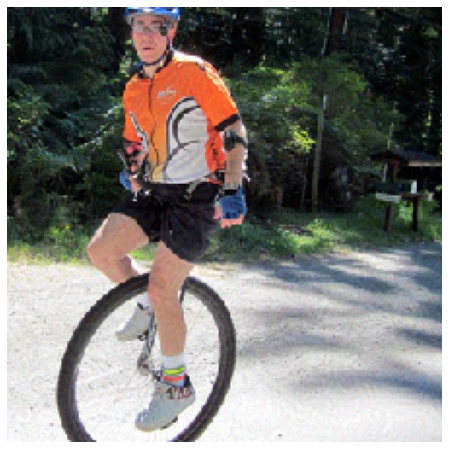

Prediction: black swan, Cygnus atratus - confidence 1.00


In [18]:
# Create the attacker.
# Note: here we use a larger number of iterations to achieve the same level of confidence in the misclassification
adv_def = ProjectedGradientDescent(classifier_def, targeted=True, max_iter=40, eps_step=1, eps=5)

# Generate the adversarial sample:
x_art_adv_def = adv_def.generate(x_art, y=to_categorical([target_label]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier_def.predict(x_art_adv_def)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

Let's also look at the $\ell_p$ norms of that adversarial perturbation:

In [19]:
l_0 = int(99*len(np.where(np.abs(x_art[0] - x_art_adv_def[0])>0.5)[0]) / (224*224*3)) + 1   
l_1 = int(99*np.sum(np.abs(x_art[0] - x_art_adv_def[0])) / np.sum(np.abs(x_art[0]))) + 1
l_2 = int(99*np.linalg.norm(x_art[0] - x_art_adv_def[0]) / np.linalg.norm(x_art[0])) + 1 
l_inf = int(99*np.max(np.abs(x_art[0] - x_art_adv_def[0])) / 255) + 1

print('Perturbation l_0 norm: %d%%' % l_0)
print('Perturbation l_1 norm: %d%%' % l_1)
print('Perturbation l_2 norm: %d%%' % l_2)
print('Noise l_inf norm: %d%%' % l_inf)

Perturbation l_0 norm: 89%
Perturbation l_1 norm: 3%
Perturbation l_2 norm: 3%
Noise l_inf norm: 2%


Comparing with the previous adversarial sample, the $\ell_0$ and $\ell_1$ norms have slightly increased, while $\ell_2$ and $\ell_\infty$ norms have stayed the same (the latter not being surprising as the PGD attack controls the $\ell_\infty$ norm budget).

## Conclusions

We have walked through an end-to-end example of using a Keras image classifier in ART, creating adversarial samples, deploying input preprocessing defences and, finally, bypassing those defences in an adaptive white-box attack.